<h2 align="center"><span style="color:black;">mpc滚动优化算法总结</span></h2>

##  [1.ackerman car使用Ipopt构造MPC控制器](https://github.com/udacity/CarND-MPC-Quizzes/blob/master/mpc_to_line/solution/MPC.cpp)

###  1.1 Ipopt对应的FG_eval()模型
 *  1.1.1 fg[0]代价函数构造(稳态误差+控制信号+控制信号增量)
 *  1.1.2 fg[i]约束条件定义(dynamic of the robot约束)

###  1.2 Ipopt求解器模型构造
 *  1.2.1 约束边界条件定义(状态量约束+控制量约束)
 *  1.2.2 求解器设置与计算结果

## [2.Matlab使用状态空间构造QP模型的求解形式](https://github.com/linqingbh/MPC-quadcopter)

### 2.1 利用MATLAB计算系统离散状态空间模型教程
 * 2.1.1 非线性标准状态空间方程
 * 2.1.2 使用jacobian矩阵在Equilibrium points对系统进行线性化
 * 2.1.3 对线性化后的系统模型进行离散化

### 2.2 构造滚动优化问题
 * 2.2.1 增广状态空间模型求解
 * 2.2.2 预测区间内的状态空间整合
 * 2.2.3 nocontrain Optimization

### 2.3 QP问题的数值解法
 * 2.3.1 quadratic problem with equality constrains
 * 2.3.2 调整QP问题中的变量把代价函数表示成deltaU的函数

<h3 align="center"><span style="color:blue;">1.1 Ipopt对应的FG_eval()模型</span></h3>

<h4 align="center"> 1.1.1 fg[0]代价函数构造 </h4>

**ackerman car状态量与控制量定义**
* states: x,y,phi -- x方向位置,y方向位置,方向角
* control input: delta,acc -- 转向角,加速度

**cost function定义**
 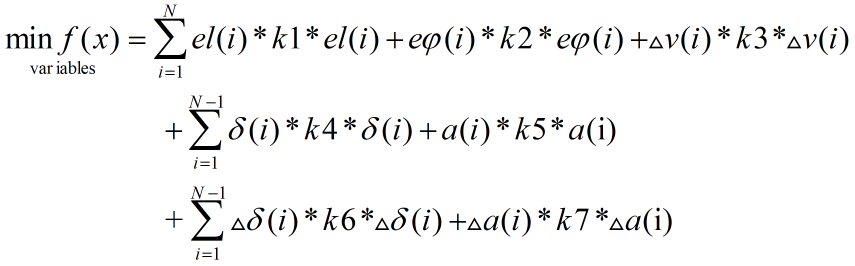

##### 预测区间内N次迭代对应的优化变量: 

###### N次迭代对应:N次状态迭代
* el:车辆横向误差(当前位置与reference轨迹的偏差)
* eψ:车辆的方位角偏差?(车辆当前的方位角与期望方位角之间的偏差)
* △v:车辆速度偏差(车辆当前速度与期望速度之间的偏差量)

<span style="color:blue;">代码展示:</span>

In [ ]:
for (int t = 0; t < N; ++t) {
    fg[0] += k1*CppAD::pow(vars[cte_start + t], 2);
    fg[0] += k2*CppAD::pow(vars[epsi_start + t], 2);
    fg[0] += k3*CppAD::pow(vars[v_start + t] - ref_v, 2);
}

<span style="color:red;">**疑问:**是不是只应该对N-1次状态量误差进行加权后累加,因为初始状态量误差无法进行约束???</span>

###### N次迭代对应:N-1次控制量输入
* δ:车辆前轮转向角控制量
*  a:车辆加速度控制量
* <span style="color:orange;">**note:此处的N不代表N个预测区间,而是对应N个状态向量,即对应N-1个预测区间** </span>

<span style="color:blue;">代码展示:</span>

In [ ]:
for (int t = 0; t < N - 1; ++t) {
  fg[0] += k4*CppAD::pow(vars[delta_start + t], 2);
  fg[0] += k5*CppAD::pow(vars[a_start + t], 2);
}

###### N次迭代对应:N-1次控制量输入&N-2次控制信号增量
* △δ:车辆前轮转向角控制增量
* △a: 车辆加速度控制增量

<span style="color:blue;">代码展示:</span>

In [ ]:
for (int t = 0; t < N - 2; ++t) {
  fg[0] += k6*CppAD::pow(vars[delta_start + t + 1] - vars[delta_start + t], 2);
  fg[0] += k7*CppAD::pow(vars[a_start + t + 1] - vars[a_start + t], 2);
}

<h4 align="center"> 1.1.2 fg[i]约束条件定义 </h4>

* 预测区间内N次状态量滚动迭代(dynamic of the car): X(k+1) = A*X(k)+B*U(k)

* 将预测区间内的优化变量设置:

**<span style="color:blue;">代码展示:</span>**

In [ ]:
/*优化变量定义*/
size_t n_vars = N*6+(N-1)*2; //预测区间内的优化状态量个数+优化控制控制量个数
Dvector vars(N*6+(N+1)*2);   //定义优化问题的优化变量

In [ ]:
size_t x_start = 0;                        //position x在vars向量中的index起始位
size_t y_start = x_start + N;              //position y在vars向量中的index起始位
size_t psi_start = y_start + N;            //方向角状态量在vars向量中的index起始位
size_t v_start = psi_start + N;            //速度状态量index起始位
size_t cte_start = v_start + N;            //横向误差对应的index起始位
size_t epsi_start = cte_start + N;         //方向角误差对应的index起始位
size_t delta_start = epsi_start + N;       //转向控制量对应的index起始位(N-1)个元素
size_t a_start = delta_start + N - 1;      //加速度控制量对应的index起始位(N-1)个元素

* 状态量滚动迭代:X(k+1) = AX(k)+BU(k)约束方程

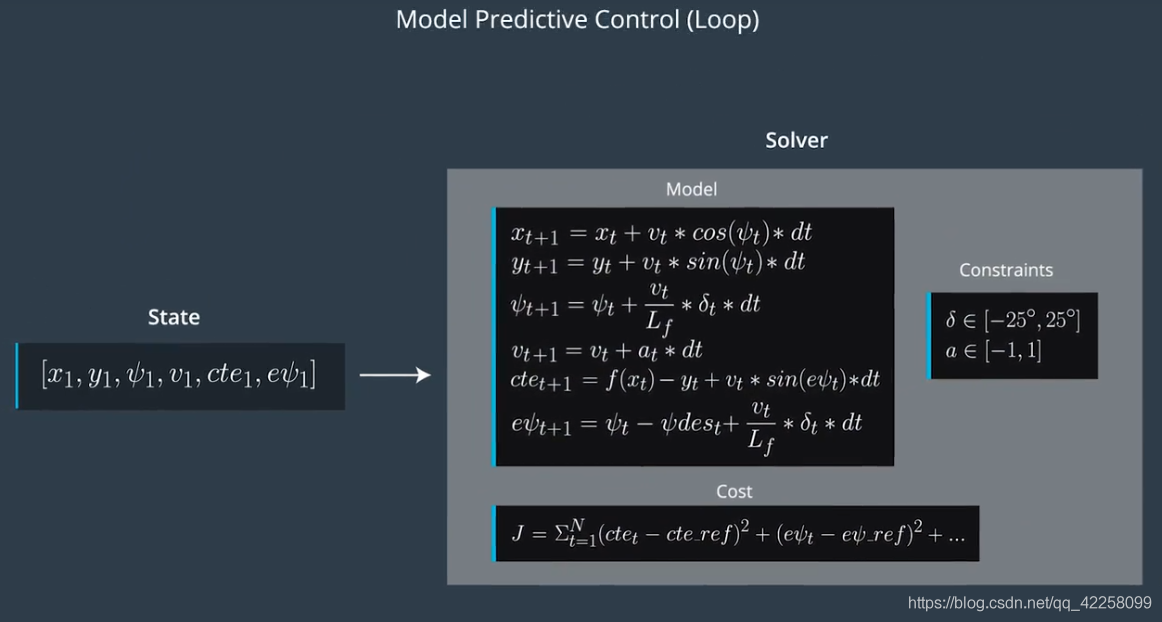

<span style="color:red;">note:</span>期望的误差信号:cte_ref=0,eψ_ref=0;     //期望的误差信号为0

* 离散状态空间微分方程:
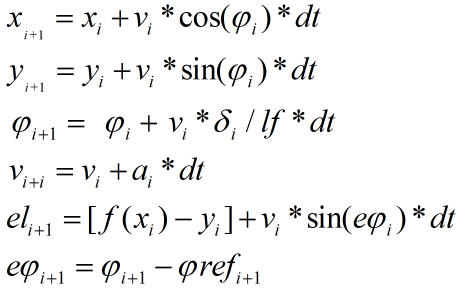

对预测区间内的所有变量进行优化,i∈[1,N]

### **期望状态计算:**

多项式拟合:计算当前时刻期望的横向位置,y_ref

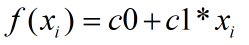

期望的方向角:φi=atan(c1);

**<span style="color:blue;">代码展示:</span>**

In [ ]:
/*预测区间初始状态量约束*/
fg[1 + x_start] = vars[x_start];            //equal to x
fg[1 + y_start] = vars[y_start];            //equal to y
fg[1 + psi_start] = vars[psi_start];        //equal to φ
fg[1 + v_start] = vars[v_start];            //equal to v
fg[1 + cte_start] = vars[cte_start];        //equal to el
fg[1 + epsi_start] = vars[epsi_start];      //equal to eφ

[x, y, φ, v, el, eφ]=>MPC滚动优化控制器当前时刻状态量用于滚动优化,计算N个预测区间内的状态量

<span style="color:blue;">代码展示:</span>

In [ ]:
/*状态量滚动更新*/
for (int t = 1; t < N; ++t) {
  /*定义临时变量:下一时刻状态*/
  AD<double> x1 = vars[x_start + t];
  AD<double> y1 = vars[y_start + t];
  AD<double> psi1 = vars[psi_start + t];
  AD<double> v1 = vars[v_start + t];
  AD<double> cte1 = vars[cte_start + t];
  AD<double> epsi1 = vars[epsi_start + t];

  /*定义临时变量:当前时刻状态*/
  AD<double> x0 = vars[x_start + t - 1];
  AD<double> y0 = vars[y_start + t - 1];
  AD<double> psi0 = vars[psi_start + t - 1];
  AD<double> v0 = vars[v_start + t - 1];
  AD<double> cte0 = vars[cte_start + t - 1];
  AD<double> epsi0 = vars[epsi_start + t - 1];

  /*定义临时变量:当前控制信号*/
  AD<double> delta0 = vars[delta_start + t - 1];
  AD<double> a0 = vars[a_start + t - 1];

  /*临时变量:当前时刻期望状态*/
  AD<double> f0 = coeffs[0] + coeffs[1] * x0;
  AD<double> psides0 = CppAD::atan(coeffs[1]);

  /*状态空间迭代约束*/
  fg[1 + x_start + t] = x1 - (x0 + v0 * CppAD::cos(psi0) * dt);
  fg[1 + y_start + t] = y1 - (y0 + v0 * CppAD::sin(psi0) * dt);
  fg[1 + psi_start + t] = psi1 - (psi0 + v0 * delta0 / Lf * dt);
  fg[1 + v_start + t] = v1 - (v0 + a0 * dt);
  fg[1 + cte_start + t] = cte1 - ((f0 - y0) + (v0 * CppAD::sin(epsi0) * dt));
  fg[1 + epsi_start + t] = epsi1 - ((psi0 - psides0) + v0 * delta0 / Lf * dt);
}

<span style="color:red;">**Note:**</span> 
#####  - 入口参数: const ADvector& vars为reference变量类型,用临时变量也可以对vars变量进行约束
##### - fg[1]~fg[n_vars+1]的约束包含两个部分:
* part01->当前时刻模型状态(测量值)
* part02->预测的滚动迭代的状态量

##### - 在for loop中定义的临时变量类似于变量的传递:
* x0获取当前时刻状态
* 约束下一时刻状态x1,通过约束得到下一时刻状态量vars[t]
* 利用x0获取下一个时刻状态vars[t],迭代计算再下一时刻状态vars[t+1]

**<span style="color:green;">控制信号的边界条件:</span>**

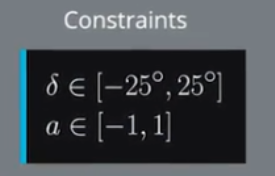

* 前轮转向角范围:[-25°,25°]
* 加速度边界范围:[-1,1]

<h3 align="center"><span style="color:blue;">1.2 Ipopt求解器模型构造</span></h3>

<h4 align="center"> 1.2.1 约束边界条件定义 </h4>

### 优化变量约束

预测区间初始状态量约束(反馈系统状态)**<span style="color:blue;"><代码展示>:</span>**

In [ ]:
double x = x0[0];
double y = x0[1];
double psi = x0[2];
double v = x0[3];
double cte = x0[4];
double epsi = x0[5];

FG_eval()优化变量初值定义**<span style="color:blue;"><代码展示>:</span>**

In [ ]:
Dvector vars(n_vars);
for (int i = 0; i < n_vars; ++i) {
  vars[i] = 0.0;
}

优化变量初值->预测区间初始状态量约束**<span style="color:blue;"><代码展示>:</span>**

In [ ]:
vars[x_start] = x;
vars[y_start] = y;
vars[psi_start] = psi;
vars[v_start] = v;
vars[cte_start] = cte;
vars[epsi_start] = epsi;

优化变量状态约束**<span style="color:blue;"><代码展示>:</span>**

<span style="color:red;">疑问:为什么没有对速度状态v进行约束,车辆速度是有限范围的啊?</span>

In [ ]:
/*边界条件定义*/ 
Dvector vars_lowerbound(n_vars);
Dvector vars_upperbound(n_vars);

/*模型状态约束:x,y,psi,v,el,epsi*/
for (int i = 0; i < delta_start; ++i) {
    vars_lowerbound[i] = -1.0e19;
    vars_upperbound[i] = 1.0e19;
}

/*转向角控制量约束条件*/
for (int i = delta_start; i < a_start; ++i) {
    vars_lowerbound[i] = -0.436332;
    vars_upperbound[i] = 0.436332;
}

/*加速度控制量约束条件
for (int i = a_start; i < n_vars; ++i) {
    vars_lowerbound[i] = -1.0;
    vars_upperbound[i] = 1.0;
}

### fg[i]边界条件约束

 size_t n_constraints = N * 6;  //状态空间对应的状态量迭代更新,N个预测区间,6个状态量更新约束

**<span style="color:blue;">代码展示:</span>**

In [ ]:
/*定义fg[i]对应的上下边界条件*/
Dvector constraints_lowerbound(n_constraints);
Dvector constraints_upperbound(n_constraints);

/*fg[i]被控对象动力学约束*/
for (int i = 0; i < n_constraints; ++i) {
    constraints_lowerbound[i] = 0;
    constraints_upperbound[i] = 0;
}

/*预测区间初始状态量约束*/
constraints_lowerbound[x_start] = x;
constraints_lowerbound[y_start] = y;
constraints_lowerbound[psi_start] = psi;
constraints_lowerbound[v_start] = v;
constraints_lowerbound[cte_start] = cte;
constraints_lowerbound[epsi_start] = epsi;

constraints_upperbound[x_start] = x;
constraints_upperbound[y_start] = y;
constraints_upperbound[psi_start] = psi;
constraints_upperbound[v_start] = v;
constraints_upperbound[cte_start] = cte;
constraints_upperbound[epsi_start] = epsi;

<h4 align="center"> 1.2.2 求解器设置与优化结果 </h4>

求解器设置**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*定义二次优化模型对象*/
FG_eval fg_eval(coeffs);
/*求解器设置*/
std::string options;
options += "Integer print_level  0\n";
options += "Sparse  true        forward\n";
options += "Sparse  true        reverse\n";
/*定义优化结果*/
CppAD::ipopt::solve_result<Dvector> solution;
/*Ipopt求解器调用*/
  CppAD::ipopt::solve<Dvector, FG_eval>(
      options, vars, vars_lowerbound, vars_upperbound, constraints_lowerbound,
      constraints_upperbound, fg_eval, solution);

求解器结果反馈**<span style="color:blue;"><代码展示></span>**:

In [ ]:
auto cost = solution.obj_value;                         //代价函数结果
std::cout << "Cost " << cost << std::endl;                  
return {solution.x[x_start + 1],   solution.x[y_start + 1],
      solution.x[psi_start + 1], solution.x[v_start + 1],
      solution.x[cte_start + 1], solution.x[epsi_start + 1],
      solution.x[delta_start],   solution.x[a_start]};

MPC滚动优化计算结果:
* 预测模型状态: x,y,psi,v
* 期望状态误差: el,epsi
* 预测控制信号: δ,a

<span style="color:red;">Note:区分代价函数表达式中的变量与优化变量之间的关系,代价函数是由优化变量重构的</span>

<h2 align="center"><span style="color:black;">2.Matlab使用状态空间构造QP模型的求解形式</span></h2>

### 教程主要内容:
* 01 使用matlab求解被控对象的线性离散状态空间模型
* 02 构造增广矩阵+compact matric form变换(综合状态空间模型)
* 03 hessian矩阵计算与无约束优化变量求解
* 04 Hildreth带约束优化问题求解

<h3 align="center"><span style="color:blue;">2.1 利用MATLAB计算系统离散状态空间模型教程</span></h3>

<span style="color:green;">01 Ipad论文:四轴无人机的MPC控制与避障算法(modeling)</span>

* [-------------论文链接-----------](http://www.diva-portal.org/smash/get/diva2:1135528/FULLTEXT01.pdf)

<span style="color:green;">02~03 Ipad论文:MPC相关方程推导与QP求解过程</span>
* [-------Model Predictive Control System Design and Implementation Using MATLAB---------](https://link.springer.com/book/10.1007/978-1-84882-331-0)

* 无人机轨迹跟踪问题的描述:(论文中包含了飞行器的动静态避障)
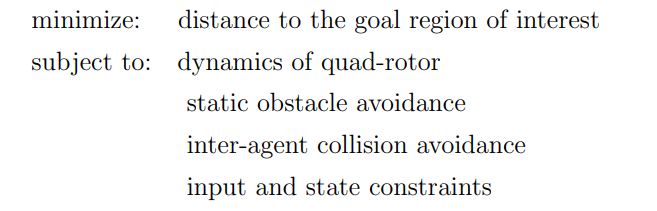

<h4 align="center"> 2.1.1 非线性标准状态空间方程 </h4>

* symbolic模型构造(系统状态微分方程)**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*定义被控对象的状态量和控制信号量*/
syms x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12    //x=[x y z vx vy vz roll pitch yaw wr wp wy]被控对象状态量
syms u1 u2 u3 u4

* 非线性系统微分方程**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*被控对象非线性微分方程表达式*/
xdot1=x4;
xdot2=x5;
xdot3=x6;
xdot4=(u1/m)*(cos(x9)*sin(x8)*cos(x7)+sin(x9)*sin(x7))-kx*x4/m+dx/m;
xdot5=(u1/m)*(sin(x9)*sin(x8)*cos(x7)-cos(x9)*sin(x7))-ky*x5/m+dy/m;
xdot6=(u1/m)*cos(x8)*cos(x7)-g-kz*x6/m+dz/m;
xdot7=x10+x11*sin(x7)*tan(x8)+x12*cos(x7)*tan(x8);
xdot8=x11*cos(x7)-x12*sin(x7);
xdot9=sin(x7)*x11/cos(x8)+cos(x7)*x12/cos(x8);
xdot10=(u2/Ix)-((Iy-Iz)/Ix)*x11*x12;
xdot11=(u3/Iy)-((Iz-Ix)/Iy)*x10*x12;
xdot12=(u4/Iz)-((Ix-Iy)/Iz)*x10*x11;

##### 小角度定理简化系统模型微分方程
- 系统稳态:(x1,x2,x3,0,0,0,0,0,0,0,0,0)
- 小角度假设:sin x -> x; cos x -> 1; tan x -> x

<span style="color:green;">论文中的解释:<span>
    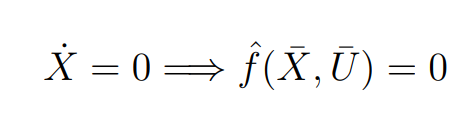
* 确定系统稳态->解微分方程->得到系统equilibrium point

**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*简化后的系统微分方程*/
xdot1=x4;
xdot2=x5;
xdot3=x6;
xdot4=(u1/m)*(x8+x9*x7)-kx*x4/m;
xdot5=(u1/m)*(x9*x8-x7)-ky*x5/m;
xdot6=(u1/m)-g-kz*x6/m;
xdot7=x10+x11*x7*x8+x12*x8;
xdot8=x11-x12*x7;
xdot9=x7*x11+x12;
xdot10=(u2/Ix)-((Iy-Iz)/Ix)*x11*x12;
xdot11=(u3/Iy)-((Iz-Ix)/Iy)*x10*x12;
xdot12=(u4/Iz)-((Ix-Iy)/Iz)*x10*x11;

* 构造state space向量元素**<span style="color:blue;"><代码展示></span>**:

In [ ]:
xdot=[xdot1 xdot2 xdot3 xdot4 xdot5 xdot6 xdot7 xdot8 xdot9 xdot10 xdot11 xdot12].'; //被控对象状态量微分
x=[x1 x2 x3 x4 x5 x6 x7 x8 x9 x10 x11 x12].'; //被控对象状态量
u=[u1 u2 u3 u4].';                            //控制输入:u=[T tr tp ty],推力+力矩
y=[x1 x2 x3 x9].';                            //系统输出:位置状态+yaw偏航角 

<h4 align="center"> 2.1.2 模型线性化 </h4>

* xdot = F(x,u) = 0:计算系统稳态**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*Equilibrium points,四轴飞行器稳定飞行状态*/
ue=[m*g 0 0 0].';
xe=[x1 x2 x3 0 0 0 0 0 0 0 0 0].';

* 微分方程求偏导=>雅克比矩阵**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*计算雅克比矩阵,xdot=f(X,U),求偏导*/
JA=jacobian(xdot,x.');
JB=jacobian(xdot,u.');
JC=jacobian(y, x.');

* 带入Equilibrium points计算状态空间matrixs(泰勒展开)**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*带入系统稳态,得到线性化后的雅克比矩阵*/
A=subs(JA,[x,u],[xe,ue]); A=eval(A);   //A=eval(A),将A转化为矩阵的形式
B=subs(JB,[x,u],[xe,ue]); B=eval(B);
C=subs(JC,[x,u],[xe,ue]); C=eval(C);

* 将计算得到的linear continue state space转化为linear discrete state space**<span style="color:blue;"><代码展示></span>**:

In [ ]:
/*Discrete state-space model*/
fs=50;               % 100 Hz
Ts=1/fs; 
sysc=ss(A,B,C,0);
sysd=c2d(sysc,Ts);  //根据时间步长对系统状态空间模型进行离散
/*计算离散的系统状态空间矩阵*/
Am=sysd.A;
Bm=sysd.B;
Cm=sysd.C;
Dm=zeros(x_size,1);

<span style="color:red;">**疑问:**</span>
  * 1 deltaT在离散的过程中起什么作用,为什么会对矩阵计算产生影响?
  * 2 error based state space,与误差相关的状态空间矩阵求解---上述书中链接:page-5解释
      * 答:与原始的状态空间模型一致,只有控制量变成了控制信号差值(实际控制量-稳态控制量(前馈))
      *   且状态量变成了状态误差

<h3><span style="color:red;">被控对象离散状态空间计算总结</span></h3>

* step01:被控对象微分方程
* step02:利用matlab sybolic系统建模工具,建立xdot = F(x,u)和模型的向量形式
* step03:根据系统equilibrium point对微分方程进行简化(xdot=f(x,u)=0=>xe,ue)
* step04:计算雅克比矩阵+带入equilibrium point(泰勒展开)=>连续线性状态空间模型
* step05:根据时间步长deltaT计算离散的系统状态空间模型

<h3 align="center"><span style="color:blue;">2.2 构造滚动优化问题(one Optimization Window)</span></h3>

<h4 align="center"> 2.2.1 增广状态空间模型求解 </h4>

* 标准的状态空间模型
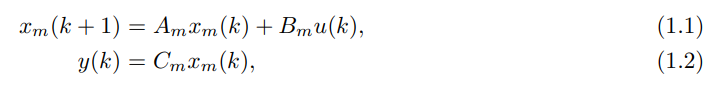

* 误差形式的状态空间方程计算
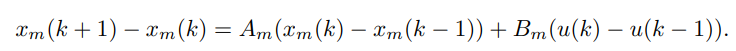

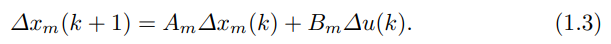

* 增广状态量:
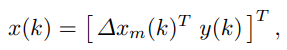

* 增广状态空间矩阵
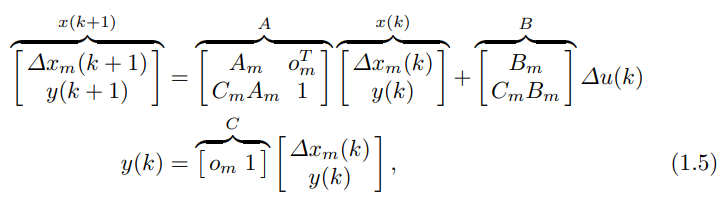

<h4 align="center"> 2.2.2 预测区间内的状态空间整合 </h4>

* 预测区间Np内的状态量求解
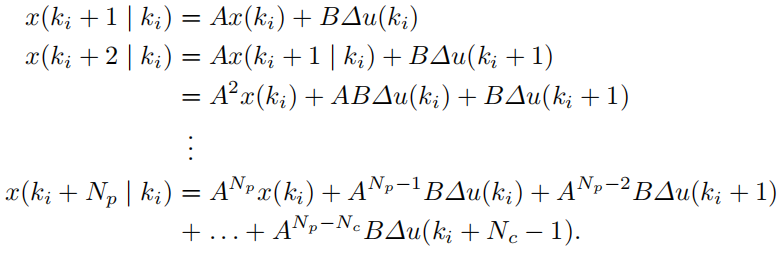

* 设定prediction horizon和control horizon
 * Np = 10; //设定预测区间,对未来Np的模型状态进行迭代计算
 * Nc = 4;  //设定控制区间,对未来Nc次的模型状态迭代进行控制,Nc~Np次迭代,不进行控制△u = 0;

* 预测区间内的状态量迭代:
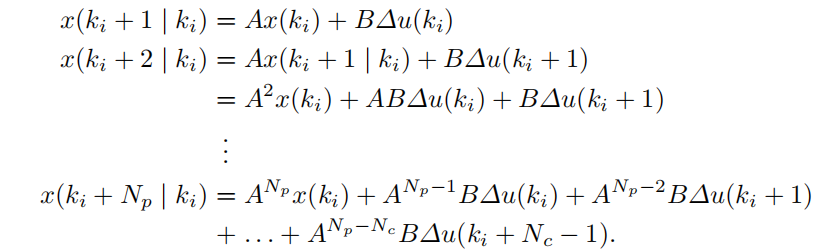

* 预测区间内的系统输出迭代:
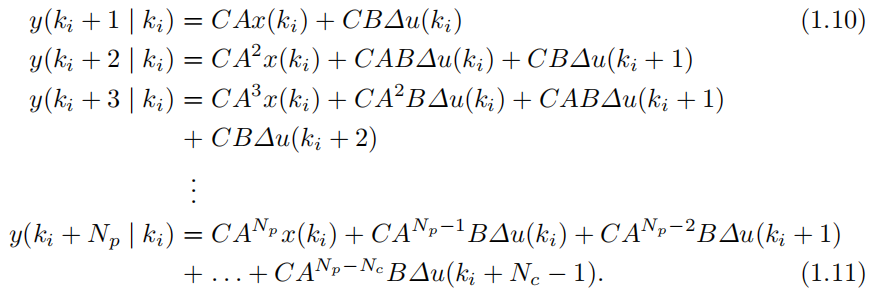

<span style="color:red;">Note:预测区间内的状态量和输出结果迭代整合中的矩阵(A,B,C)对应增广状态空间中的矩阵
</span>

<span style="color:red;">疑问:不同的增广状态向量对应的上述综合迭代过程是否一致???
</span>

* 表示成compact matrix form,紧密矩阵形式
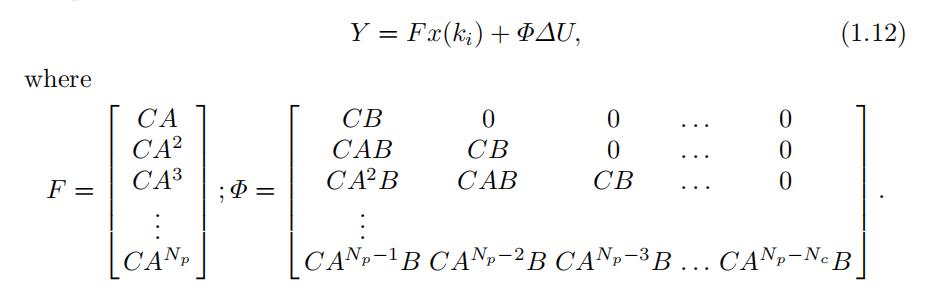

* Toeplitz matrix φ:
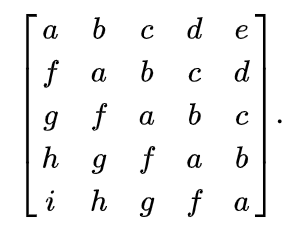
which is created by defining its first column, and the next column is obtained through shifting the previous column

<span style="color:red;">Note:案例教程查看<书>中Tutorial 1.2案例与代码</span>

<h4 align="center"> 2.2.3 unconstrain Optimizition </h4>

* cost function代价函数:
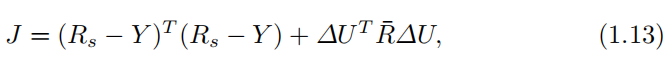

Rs:预测区间内期望的输出结果(模型中对应无人机的reference trajectory和期望偏航角)

<span style="color:red;">Note:不增加稳态误差的权重</span>

* 变形后的代价函数:
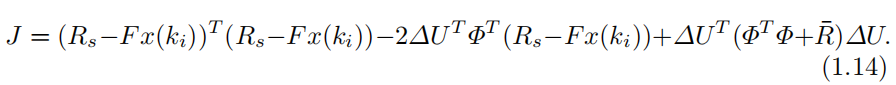

<h4><span style="color:red;">代价函数的解释:</span></h4>

* 01:代价函数没有对系统稳态误差增加权重系数Q矩阵
* 02:变形后的代价函数优化变量只有△U,其中Rs和x(ki)均为常量,即函数J为△U的函数
* 03:代价函数的优化目标对应=>系统稳态误差&控制信号增量△U=0


* 优化目标的确定:
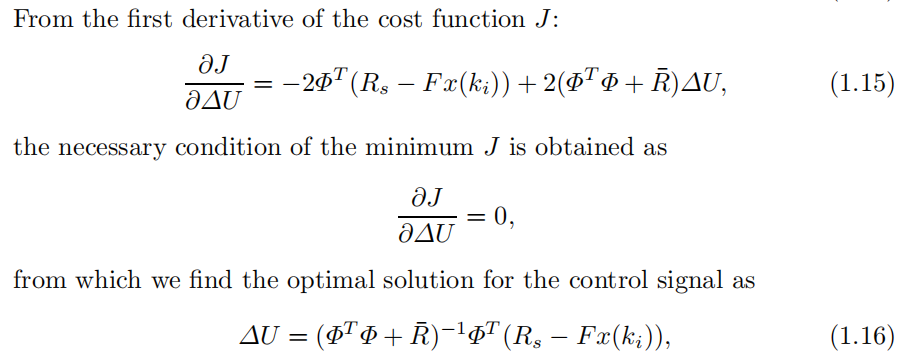

说明:极值处导数为零

* Hessian matrix: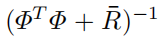

* Computation of MPC gains:



<span style="color:blue;">代码展示:</span>

In [ ]:
function [Phi_Phi,Phi_F,Phi_R,A_e, B_e,C_e]= mpcgain(Ap,Bp,Cp,Nc,Np);
    /*定义增广矩阵*/
    [nOutput,nState]=size(Cp);
    [nState,nInput]=size(Bp);
    /*状态增广矩阵(判断行/列size的方法看相乘矩阵对应的行列)*/
    A_e=eye(nState+nOutput,nState+nOutput);  //定义size of augmented state matrix 
    A_e(1:nState,1:nState)=Ap;                       
    A_e(nState+1:nState+Output,1:nState)=Cp*Ap;
    /*控制信号增广矩阵*/
    B_e=zeros(nState+nOutput,nOutput);       //定义size of augmented input matrix
    B_e(1:nState,:)=Bp;
    B_e(nState+1:nState+nOutput,:)=Cp*Bp;
    /*系统输出增广矩阵*/
    C_e=zeros(nOutput,nState+nOutput);      //定义size of augmented output matrix
    C_e(:,nState+1:nState+nOutput)=eye(nOutput,nOutput);

<span style="color:blue;">代码展示:</span>

In [ ]:
num = nState + nOutput;            //增广状态空间状态量
h(1,:)=C_e;
/*构造F矩阵*/
F(1,:)=C_e*A_e;                    //F矩阵第一行元素计算
for kk=2:Np
    h(kk,:)=h(kk-1,:)*A_e;  
    F(kk,:)= F(kk-1,:)*A_e;        //F矩阵从第二行迭代计算
end
/* 构造φ矩阵*/
v=h*B_e;                           //φ矩阵第一列元素
Phi=zeros(Np,Nc);                   % declare the dimension of Phi
Phi(:,1)=v;                         % first column of Phi
/*构造Toeplitz矩阵*/
for i=2:Nc
    Phi(:,i)=[zeros(i-1,1);v(1:Np-i+1,1)];
end
BarRs=ones(Np,1);      //reference output vector
/*计算φ'φ, φ'F, φ'Rs矩阵*/
Phi_Phi= Phi’*Phi;   
Phi_F= Phi’*F;
Phi_R=Phi’*BarRs;

<h3 align="center"><span style="color:blue;">2.3 QP问题的数值解法</span></h3>

<h4 align="center"> 2.3.1 QP with equality constrains </h4>

**note: QP问题中的等价约束与Ipopt求解器中fg[i]对应的模型微分方程状态量迭代约束一致,实质就是等价约束**

##### 数值解计算核心:
* QP问题的标准表达式:E,F矩阵
* 等式约束:M,γ矩阵
* 拉格朗日乘子:λ

* 二次优化问题的标准形式
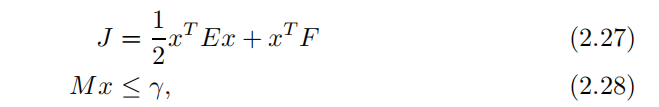

矩阵E,F,M与向量γ为标准QP问题中的特定符号变量

* 等式约束:引入拉格朗日乘子
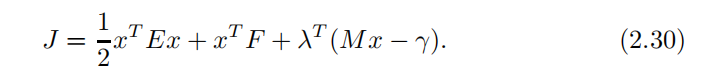

* 等式约束条件:
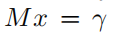

* 偏导计算全局最优解:
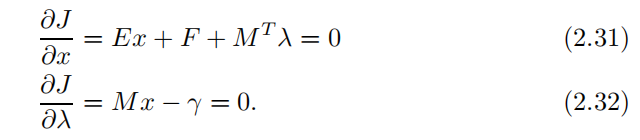

**NOTE:新的cost function包含x和λ两组优化变量,需要对两组变量分别求导计算最优解**

* 解线性方程得到拉格朗日乘子与优化变量的global optimal decision variables:
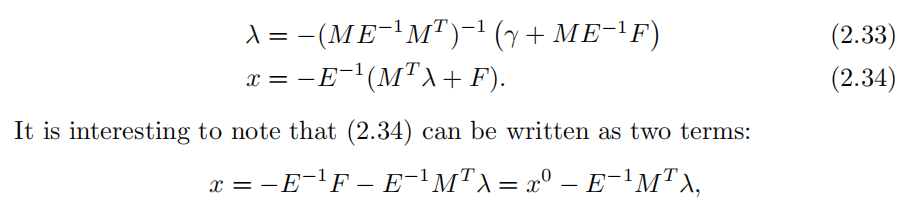

* decision variables x对应的全局优化解:
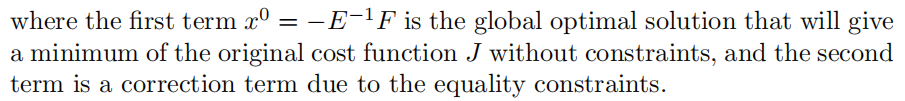

<h4><span style="color:red;">全局最优解的计算串联:</span></h4>

* noconstrains optimization问题对应的数值解与标准QP表达式之间的关系
* QP问题全局优化解与无约束优化的数值解之间的关系

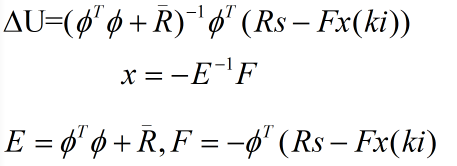

<h4 align="center"> 2.3.1 inequality constrainssh数值解法 </h4>

##### 不等式约束Primal-Dual Method(具体描述看书中2.4.3章节)
* 其实质是将拉个朗日乘子作为优化变量,简化约束条件

* QP问题的Hildreth算法:
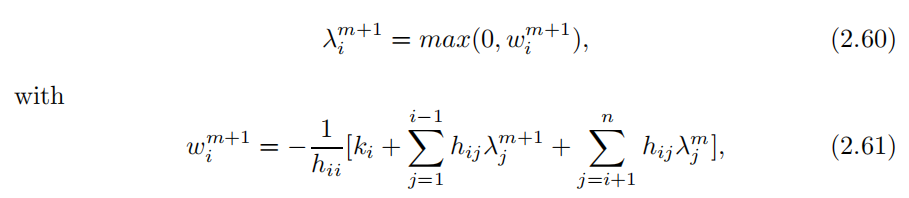

**计算收敛的λ(书中表述λ中的0元素对应inactive constrain,正元素对应active constrain)**

<span style="color:red;">公式2.61非常难以理解,但是对应的代码相对比较简单,可以结合代码分析实现方式

* primal-Dual对应的代价函数与相应元素计算
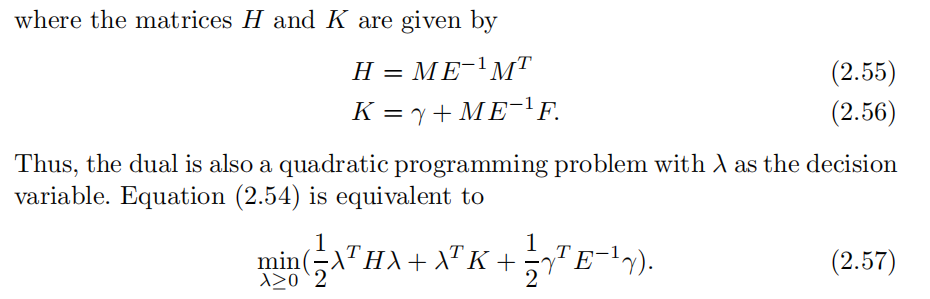

计算拉格朗日乘子<span style="color:blue;"><代码展示>:</span>

In [ ]:
x_ini=zeros(n,m); 
lambda=x_ini;   //定义初始的拉格朗日乘子
al=10;          //定义差值变量
for km=1:38
    %find the elements in the solution vector one by one
    % km could be larger if the Lagranger multiplier has a slow
    % convergence rate.
    lambda_p=lambda;  //记录上一次迭代对应的拉格朗日乘子
    /*拉格朗日乘子迭代计算*/
    for i=1:n
        w= H(i,:)*lambda-H(i,i)*lambda(i,1);  //上述的公式2.61
        w=w+K(i,1);
        la=-w/H(i,i);                         //拉格朗日乘子表达式
        lambda(i,1)=max(0,la);
    end
    /*判断相邻两次迭代对应的拉格朗日乘子是否相等*/
    al=(lambda-lambda_p)'*(lambda-lambda_p);
    if (al<10e-8); 
        break; 
    end
end

* 利用得到的拉格朗日乘子计算QP问题的最优解:
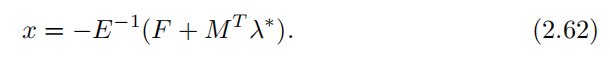

* 项目中约束的表达形式

## 分析ipopt求解器和matlab在计算mpc问题时的本质不同